In [11]:
from __future__ import print_function

import numpy as np

import gtsam

import matplotlib.pyplot as plt
import gtsam.utils.plot as gtsam_plot
from gtsam.utils.circlePose3 import *
%matplotlib inline
# Create noise models
ODOMETRY_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([1, 1, 1, 0.5, 0.5, 0.5]))
PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([10, 10, 1]))
GPS_NOISE = gtsam.noiseModel.Isotropic.Sigmas(np.array([1, 1, 1]))


In [8]:
def X(i):
    """Create key for pose i."""
    return int(gtsam.symbol(ord('x'), i))


In [9]:
class Factor(object):
    def __init__(self):
        # Create an empty nonlinear factor graph
        # self.delta = p0.between(p1)

        # self.graph = gtsam.NonlinearFactorGraph()
        # self.initial = gtsam.Values()
        # init_pose = gen_pose([0,0,0])
        # self.graph.add(gtsam.NonlinearEqualityPose3(1, init_pose))
        # self.initial.insert(1, init_pose)

        self.result = None
        self.marginals = None
        self.node_idx = 0

        #! Define Gtsam2
        parameters = gtsam.ISAM2Params()
        parameters.setRelinearizeThreshold(0.01)
        parameters.setRelinearizeSkip(1)
        self.isam = gtsam.ISAM2(parameters)

        #! Create a Factor Graph and Values to hold the new data
        self.graph = gtsam.NonlinearFactorGraph()
        self.initial_estimate = gtsam.Values()
        self.init_pose = gen_pose([0,0,0])

        #! Add a prior on pose x0
        pose_noise = gtsam.noiseModel_Diagonal.Sigmas(np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1]))
        self.graph.push_back(gtsam.PriorFactorPose3(X(self.node_idx), self.init_pose, pose_noise))
        self.initial_estimate.insert(X(self.node_idx), self.init_pose)
        self.current_estimate = None

        self.count_index = 0
        self.est_pose = []
        self.pre_pose = None

    def cur_index(self):
        return self.node_idx

    def add_odom(self, delta, cur_pose):
        # TODO Current with fixed angle
        self.graph.add(gtsam.BetweenFactorPose3(X(self.node_idx), X(self.node_idx+1), delta, ODOMETRY_NOISE))
        if self.count_index == 0:
            self.initial_estimate.insert(X(self.node_idx+1), cur_pose)
        else:
            last_id = self.current_estimate.size()-1
            self.initial_estimate.insert(X(self.node_idx+1), self.current_estimate.atPose3(X(last_id)).compose(delta))
        self.node_idx += 1
        self.count_index += 1

        # TODO add jump connections

        if self.node_idx >=6:
            pose1 = self.current_estimate.atPose3(X(self.node_idx-6))
            pose2 = self.current_estimate.atPose3(X(self.node_idx-5))
            pose3 = self.current_estimate.atPose3(X(self.node_idx-4))
            pose4 = self.current_estimate.atPose3(X(self.node_idx-3))
            pose5 = self.current_estimate.atPose3(X(self.node_idx-2))
            pose6 = self.current_estimate.atPose3(X(self.node_idx-1))
            #* 1->3 2->4 3->5 4->6
            self.graph.add(gtsam.BetweenFactorPose3(X(self.node_idx-6), X(self.node_idx-4), pose1.between(pose3), ODOMETRY_NOISE))
            self.graph.add(gtsam.BetweenFactorPose3(X(self.node_idx-5), X(self.node_idx-3), pose2.between(pose4), ODOMETRY_NOISE))
            self.graph.add(gtsam.BetweenFactorPose3(X(self.node_idx-4), X(self.node_idx-2), pose3.between(pose5), ODOMETRY_NOISE))
            self.graph.add(gtsam.BetweenFactorPose3(X(self.node_idx-3), X(self.node_idx-1), pose4.between(pose6), ODOMETRY_NOISE))
            #* 1->4 2->5 3->6
            self.graph.add(gtsam.BetweenFactorPose3(X(self.node_idx-6), X(self.node_idx-3), pose1.between(pose4), ODOMETRY_NOISE))                        
            self.graph.add(gtsam.BetweenFactorPose3(X(self.node_idx-5), X(self.node_idx-2), pose2.between(pose5), ODOMETRY_NOISE))                        
            self.graph.add(gtsam.BetweenFactorPose3(X(self.node_idx-4), X(self.node_idx-1), pose3.between(pose6), ODOMETRY_NOISE))                        
            #* 1->5 2->6
            self.graph.add(gtsam.BetweenFactorPose3(X(self.node_idx-6), X(self.node_idx-2), pose1.between(pose5), ODOMETRY_NOISE))                        
            self.graph.add(gtsam.BetweenFactorPose3(X(self.node_idx-5), X(self.node_idx-1), pose2.between(pose6), ODOMETRY_NOISE))
            #* 1->6
            self.graph.add(gtsam.BetweenFactorPose3(X(self.node_idx-6), X(self.node_idx-1), pose1.between(pose6), ODOMETRY_NOISE))

    def add_vpr(self, pose_vpr, cov):
        GPS_NOISE = gtsam.noiseModel_Isotropic.Sigmas(np.array([20, 20, 10])*cov)
        gps = gtsam.Point3(pose_vpr[0], pose_vpr[1], 0.0)
        self.graph.add(gtsam.GPSFactor(X(self.node_idx), gps, GPS_NOISE))
        self.est_pose.append(pose_vpr)

    def optimize(self):
        # import pdb; pdb.set_trace()
        self.isam.update(self.graph, self.initial_estimate)
        self.isam.update()
        self.isam.update()
        self.isam.update()
        self.isam.update()
        self.isam.update()
        self.current_estimate = self.isam.calculateEstimate()

        self.graph.resize(0)
        self.initial_estimate.clear()

    def get_cur_estimate(self):
        i = 0
        points = []
        while self.current_estimate.exists(X(i)):
            pose_i = self.current_estimate.atPose3(X(i))
            # gtsam_plot.plot_pose3(fignum, pose_i, 10)
            points.append(np.array([pose_i.x(), pose_i.y(), 0]))
            i += 1
        return points

    def plot(self,loam_traj, cov):
        # fig = plt.figure(0)
        # point = []

        # for i in range(1, self.node_idx):
        #     pose = self.result.atPose3(i)
        #     point.append(np.array([pose.x(), pose.y(), 0]))
        #     gtsam_plot.plot_pose2(0, gtsam.Pose2(pose.x(), pose.y(), 0))
        # plt.axis('equal')
        # plt.show()
        # return point
        visual_ISAM2_plot(self.current_estimate, self.est_pose, loam_traj, cov)

In [5]:
"""
GTSAM Copyright 2010, Georgia Tech Research Corporation,
Atlanta, Georgia 30332-0415
All Rights Reserved
Authors: Frank Dellaert, et al. (see THANKS for the full author list)
See LICENSE for the license information
A visualSLAM example for the structure-from-motion problem on a simulated dataset
This version uses iSAM to solve the problem incrementally
"""

from __future__ import print_function

import numpy as np
import gtsam
from gtsam.examples import SFMdata
from gtsam import (Cal3_S2, GenericProjectionFactorCal3_S2,
                   NonlinearFactorGraph, NonlinearISAM, Pose3,
                   PriorFactorPoint3, PriorFactorPose3, Rot3,
                   PinholeCameraCal3_S2, Values, Point3)
from gtsam.symbol_shorthand import X, L

def main():
    """
    A structure-from-motion example with landmarks
    - The landmarks form a 10 meter cube
    - The robot rotates around the landmarks, always facing towards the cube
    """

    # Define the camera calibration parameters
    K = Cal3_S2(50.0, 50.0, 0.0, 50.0, 50.0)

    # Define the camera observation noise model
    camera_noise = gtsam.noiseModel.Isotropic.Sigma(
        2, 1.0)  # one pixel in u and v

    # Create the set of ground-truth landmarks
    points = SFMdata.createPoints()
    # Create the set of ground-truth poses
    poses = SFMdata.createPoses(K)

    # Create a NonlinearISAM object which will relinearize and reorder the variables
    # every "reorderInterval" updates
    isam = NonlinearISAM(reorderInterval=3)

    # Create a Factor Graph and Values to hold the new data
    graph = NonlinearFactorGraph()
    initial_estimate = Values()

    # Loop over the different poses, adding the observations to iSAM incrementally
    for i, pose in enumerate(poses):
        camera = PinholeCameraCal3_S2(pose, K)
        # Add factors for each landmark observation
        for j, point in enumerate(points):
            measurement = camera.project(point)
            factor = GenericProjectionFactorCal3_S2(
                measurement, camera_noise, X(i), L(j), K)
            graph.push_back(factor)

        # Intentionally initialize the variables off from the ground truth
        noise = Pose3(r=Rot3.Rodrigues(-0.1, 0.2, 0.25),
                      t=Point3(0.05, -0.10, 0.20))
        initial_xi = pose.compose(noise)

        # Add an initial guess for the current pose
        initial_estimate.insert(X(i), initial_xi)

        # If this is the first iteration, add a prior on the first pose to set the coordinate frame
        # and a prior on the first landmark to set the scale
        # Also, as iSAM solves incrementally, we must wait until each is observed at least twice before
        # adding it to iSAM.
        if i == 0:
            # Add a prior on pose x0, with 0.3 rad std on roll,pitch,yaw and 0.1m x,y,z
            pose_noise = gtsam.noiseModel.Diagonal.Sigmas(
                np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1]))
            factor = PriorFactorPose3(X(0), poses[0], pose_noise)
            graph.push_back(factor)

            # Add a prior on landmark l0
            point_noise = gtsam.noiseModel.Isotropic.Sigma(3, 0.1)
            factor = PriorFactorPoint3(L(0), points[0], point_noise)
            graph.push_back(factor)

            # Add initial guesses to all observed landmarks
            noise = np.array([-0.25, 0.20, 0.15])
            for j, point in enumerate(points):
                # Intentionally initialize the variables off from the ground truth
                initial_lj = points[j] + noise
                initial_estimate.insert(L(j), initial_lj)
        else:
            # Update iSAM with the new factors
            isam.update(graph, initial_estimate)
            current_estimate = isam.estimate()
            print('*' * 50)
            print('Frame {}:'.format(i))
            current_estimate.print_('Current estimate: ')

            # Clear the factor graph and values for the next iteration
            graph.resize(0)
            initial_estimate.clear()


In [6]:
main()

**************************************************
Frame 1:
**************************************************
Frame 2:
**************************************************
Frame 3:
**************************************************
Frame 4:
**************************************************
Frame 5:
**************************************************
Frame 6:
**************************************************
Frame 7:



Factor Graph:
size: 3

Factor 0: PriorFactor on 1
  prior mean: (0, 0, 0)
  noise model: diagonal sigmas[0.3; 0.3; 0.1];

Factor 1: BetweenFactor(1,2)
  measured: (2, 0, 0)
  noise model: diagonal sigmas[0.2; 0.2; 0.1];

Factor 2: BetweenFactor(2,3)
  measured: (2, 0, 0)
  noise model: diagonal sigmas[0.2; 0.2; 0.1];



Initial Estimate:
Values with 3 values:
Value 1: (gtsam::Pose2)
(0.5, 0, 0.2)

Value 2: (gtsam::Pose2)
(2.3, 0.1, -0.2)

Value 3: (gtsam::Pose2)
(4.1, 0.1, 0.1)



Final Result:
Values with 3 values:
Value 1: (gtsam::Pose2)
(7.46978309e-16, -5.34409095e-16, -1.78381861e-16)

Value 2: (gtsam::Pose2)
(2, -1.09236636e-15, -2.48671177e-16)

Value 3: (gtsam::Pose2)
(4, -1.70076056e-15, -2.50943862e-16)


X1 covariance:
[[9.00000000e-02 3.19488667e-33 2.83989926e-33]
 [3.19488667e-33 9.00000000e-02 2.55795385e-17]
 [2.83989926e-33 2.55795385e-17 1.00000000e-02]]

X2 covariance:
[[1.30000000e-01 1.21229812e-18 6.06149061e-19]
 [1.21229812e-18 1.70000000e-01 2.00000000e-02]
 [

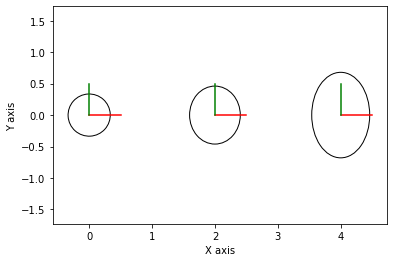

In [12]:
"""
GTSAM Copyright 2010-2018, Georgia Tech Research Corporation,
Atlanta, Georgia 30332-0415
All Rights Reserved
Authors: Frank Dellaert, et al. (see THANKS for the full author list)

See LICENSE for the license information

Simple robot motion example, with prior and two odometry measurements
Author: Frank Dellaert
"""
# pylint: disable=invalid-name, E1101

from __future__ import print_function

import numpy as np

import gtsam

import matplotlib.pyplot as plt
import gtsam.utils.plot as gtsam_plot

# Create noise models
ODOMETRY_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.2, 0.2, 0.1]))
PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.1]))

# Create an empty nonlinear factor graph
graph = gtsam.NonlinearFactorGraph()

# Add a prior on the first pose, setting it to the origin
# A prior factor consists of a mean and a noise model (covariance matrix)
priorMean = gtsam.Pose2(0.0, 0.0, 0.0)  # prior at origin
graph.add(gtsam.PriorFactorPose2(1, priorMean, PRIOR_NOISE))

# Add odometry factors
odometry = gtsam.Pose2(2.0, 0.0, 0.0)
# For simplicity, we will use the same noise model for each odometry factor
# Create odometry (Between) factors between consecutive poses
graph.add(gtsam.BetweenFactorPose2(1, 2, odometry, ODOMETRY_NOISE))
graph.add(gtsam.BetweenFactorPose2(2, 3, odometry, ODOMETRY_NOISE))
print("\nFactor Graph:\n{}".format(graph))

# Create the data structure to hold the initialEstimate estimate to the solution
# For illustrative purposes, these have been deliberately set to incorrect values
initial = gtsam.Values()
initial.insert(1, gtsam.Pose2(0.5, 0.0, 0.2))
initial.insert(2, gtsam.Pose2(2.3, 0.1, -0.2))
initial.insert(3, gtsam.Pose2(4.1, 0.1, 0.1))
print("\nInitial Estimate:\n{}".format(initial))

# optimize using Levenberg-Marquardt optimization
params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)
result = optimizer.optimize()
print("\nFinal Result:\n{}".format(result))

# 5. Calculate and print marginal covariances for all variables
marginals = gtsam.Marginals(graph, result)
for i in range(1, 4):
    print("X{} covariance:\n{}\n".format(i, marginals.marginalCovariance(i)))

fig = plt.figure(0)
for i in range(1, 4):
    gtsam_plot.plot_pose2(0, result.atPose2(i), 0.5, marginals.marginalCovariance(i))
plt.axis('equal')
plt.show()


